### Portfolio Analysis based on your Risk Aversion level and timeframe
We have 3 levels of Risk Aversion, with level 3 being the most aggressive
We have 3 timeframes for which we will do our Monte Carlo forecasts: 5, 10, and 20 years.

In [1]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
import sys
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
#chaim edit 11/3/21 
from utils.writeToCSV import writeToCSV #importing to write results to CSV file
from utils.get_dates import get_start_date
from utils.get_dates import get_end_date

from utils.function_eff_front import efficient_frontier #bipasha's import for her weight optimization

#from pathlib import Path
#import csv
%matplotlib inline

In [2]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
load_dotenv()

True

In [3]:
#User inputs 
while True:
    try:
        portfolio_value = input("To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': \n")
    
        if portfolio_value == 'Quit':
            print('You have quit the program. Have a nice day.')
            
            break
        
        portfolio_value = float(portfolio_value)
        
        if portfolio_value < 1000000:
            print("Unfortunately, you do not have enough savings to invest in a portfolio. \nThe minimum required is $1,000,000.")
            sys.exit("The application is now exiting.")
    
        break
    except ValueError:
        print("Please only enter numerical digits.")

To begin, please enter the amount to be invested (USD). If you would like to quit, please enter 'Quit': 
 10000000


In [4]:
#Get user input for risk tolerance. User must input 1, 2, or 3. If risk_tolerance is not one of these, we prompt user
#to try again.
risk_tolerance = input("Please select your risk tolerance level from 1-3, 3 being the most aggressive: ")
#print(risk_tolerance)
#type if statment here
if int(risk_tolerance) == 1:
    tickers = ["JPM","VTEB","PZA","BNDX","GOOGL"]
    #weights1 = sljflsdlkfj
    print("Thank you for your response!  You are a conversative investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #JP Morgan, Vanguard Tax-Exempt Bond Index Fund ETF, Invesco National AMT-Free Municipal Bond ETF, Vanguard Total International Bond Index Fund
    #Google
elif int(risk_tolerance) == 2:
    tickers = ["FB","AAPL","TSLA","HD","GS"]
    print("Thank you for your response!  You are an aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Facebook, Apple, Tesla, Home Depot, Goldman Sachs
elif int(risk_tolerance) == 3:
    tickers = ["NFLX","ADBE","AMZN","PYPL","GME"]
    print("Thank you for your response!  You are a very aggressive investor.")
    print(f"The stocks in your portfolio will be {tickers}")
    #Netflix, Adobe, Amazon, Paypal, GameStop

else:
    print("I'm sorry, you need to enter 1, 2, or 3 for the application to work.")
#chaim edit- changed the print function to simplify output
risk_tolerance = int(risk_tolerance) #force it to be a number since the result of input() is a string



    

Please select your risk tolerance level from 1-3, 3 being the most aggressive:  2


Thank you for your response!  You are an aggressive investor.
The stocks in your portfolio will be ['FB', 'AAPL', 'TSLA', 'HD', 'GS']


In [5]:
# Set the variables for the Alpaca API and secret keys. Will be making calls for historical prices.
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


str

str

In [6]:
# Set the tickers for both the bond and stock portion of the portfolio

#This setting of tickers will also need to be made a bit more dynamic again dep on what client selects
#We know this would be risk tolerance level 2 based on Nev's list.
#tickers = ["FB","AAPL","TSLA","RDS.A","GS"] Paul Lopez moved this up on 2021-10-29 to the top depending on if client enters 1, 2, or 3 for risk tolerance

# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior business day 
# This will give you the closing price of the previous trading day
#Made it dynamic so start and end date are always T-1 business days 20211104
start_date = get_start_date() #pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
end_date = get_start_date() #pd.Timestamp("2021-10-27", tz="America/New_York").isoformat()
limit_rows = 1000
start_date

'2021-11-08T00:00:00-05:00'

In [7]:
# We use the Alpaca get_barset function to get current closing prices for our portfolio of 5 tickers
prices_df = alpaca.get_barset(tickers, timeframe, start=start_date, end=end_date, limit=limit_rows).df

# checking dataframe to make sure everything looks ok for our closes
prices_df.head()


AAPL                                        FB  \
                            open    high     low   close    volume    open   
time                                                                         
2021-11-08 00:00:00-05:00  151.4  151.57  150.16  150.45  45449352  344.38   

                                                              ...      HD  \
                              high     low   close    volume  ...    open   
time                                                          ...           
2021-11-08 00:00:00-05:00  344.789  338.34  338.53  15333904  ...  370.22   

                                                               TSLA        \
                             high     low   close   volume     open  high   
time                                                                        
2021-11-08 00:00:00-05:00  372.91  367.85  368.68  1761507  1149.69  1197   

                                                    
                            low    close    volume  
time                                                
2021-11-08 00:00:00-05:00  1133  1162.73  28835359  

[1 rows x 25 columns]

In [8]:
# Access the closing prices for our 5 tickers from the Alpaca DataFrame
# We also convert the value to a floating point number
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
stock1_close_price = float(prices_df[tickers[0]]["close"])
stock2_close_price = float(prices_df[tickers[1]]["close"])
stock3_close_price = float(prices_df[tickers[2]]["close"])
stock4_close_price = float(prices_df[tickers[3]]["close"])
stock5_close_price = float(prices_df[tickers[4]]["close"])

display(stock1_close_price)
display(stock2_close_price)
display(stock3_close_price)
display(stock4_close_price)
display(stock5_close_price)

338.53

150.45

1162.73

368.68

408.48

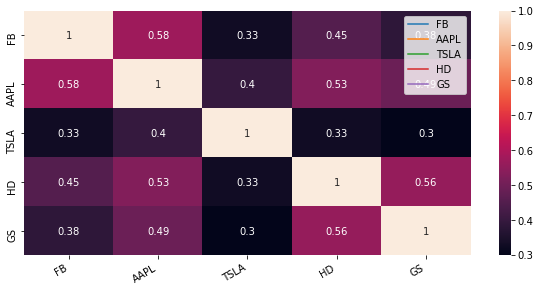

                  FB      AAPL          TSLA        HD        GS
Date                                                            
2016-01-05  0.001277 -0.006701  5.695643e-07 -0.000620 -0.005914
2016-01-06  0.000598 -0.005233 -1.249580e-04 -0.001313 -0.008385
2016-01-07 -0.012549 -0.011285 -9.842707e-05 -0.003617 -0.010557
2016-01-08 -0.001542  0.001414 -1.371335e-04 -0.001518 -0.001419
2016-01-11  0.000473  0.004330 -9.494425e-05  0.001925  0.003750


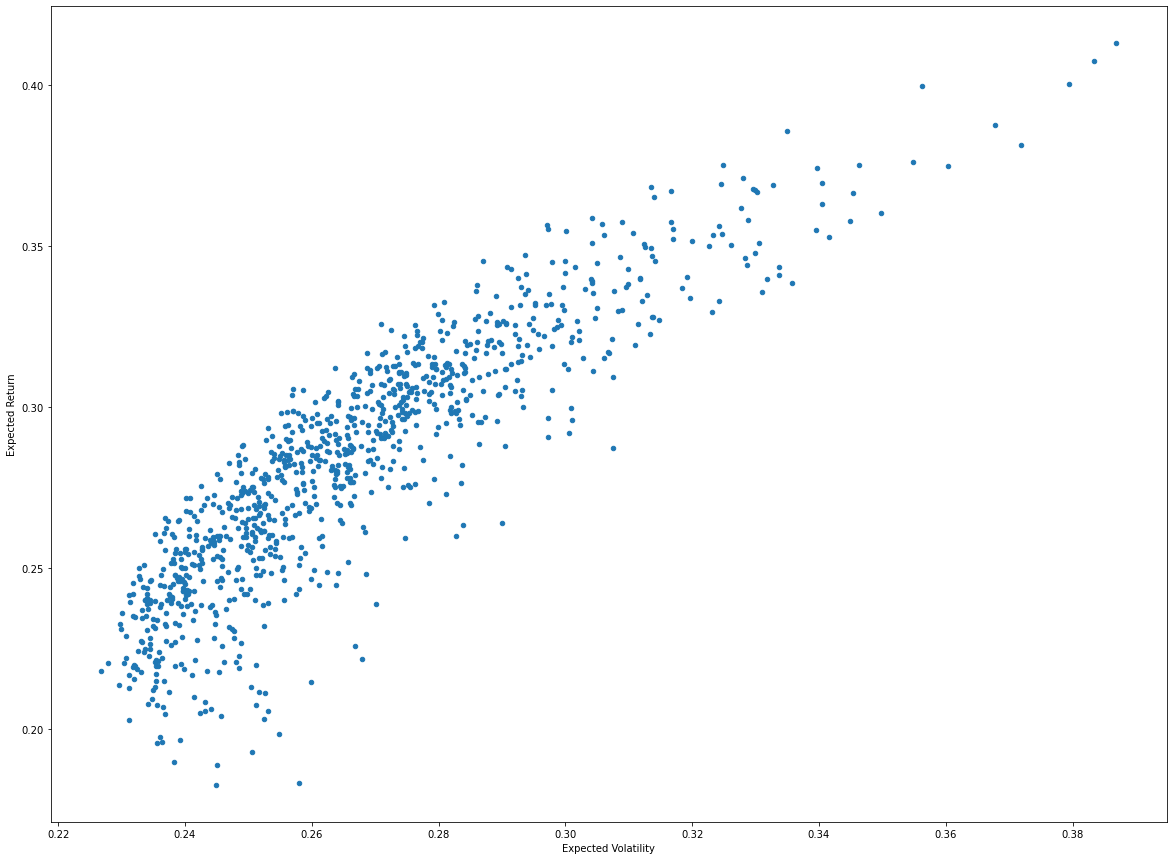

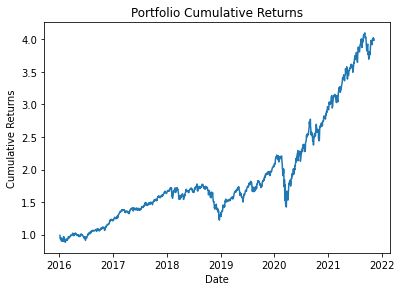

With $2558766.09 you will be able to purchase 7558 shares of FB.
With $2673995.05 you will be able to purchase 17773 shares of AAPL.
With $63597.47 you will be able to purchase 55 shares of TSLA.
With $1268812.68 you will be able to purchase 3442 shares of HD.
With $3434828.71 you will be able to purchase 8409 shares of GS.


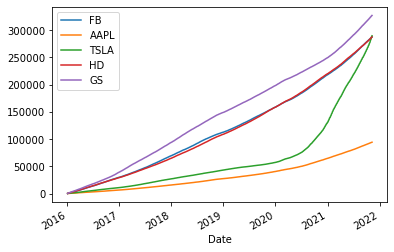

In [9]:
# Calculate the current value of the bond portion of the portfolio
#Again will need to be made dynamic depending on if level 1 2 or 3 risk tolerance level is selected
#value_per_share = portfolio_value/5 

weights_eff = efficient_frontier(tickers) #[num1, num2, num3, num4, num5]

weight1 = weights_eff[0]
weight2 = weights_eff[1]
weight3 = weights_eff[2]
weight4 = weights_eff[3]
weight5 = weights_eff[4]


#Paul Lopez added sample code for Bipasha to use when her dynamic weights- 20211103
value_share1 = portfolio_value * weight1 #weight1 will be the weight as determined by Bipasha's algorithm
value_share2 = portfolio_value * weight2
value_share3 = portfolio_value * weight3
value_share4 = portfolio_value * weight4
value_share5 = portfolio_value * weight5


stock1_shares = value_share1 / stock1_close_price
stock2_shares = value_share2 / stock2_close_price
stock3_shares = value_share3 / stock3_close_price
stock4_shares = value_share4 / stock4_close_price
stock5_shares = value_share5 / stock5_close_price

# Print how many shares we get of each stock assuming 200k is available for each one.
print(f"With ${value_share1:.2f} you will be able to purchase {stock1_shares:.0f} shares of {tickers[0]}.")
print(f"With ${value_share2:.2f} you will be able to purchase {stock2_shares:.0f} shares of {tickers[1]}.")
print(f"With ${value_share3:.2f} you will be able to purchase {stock3_shares:.0f} shares of {tickers[2]}.")
print(f"With ${value_share4:.2f} you will be able to purchase {stock4_shares:.0f} shares of {tickers[3]}.")
print(f"With ${value_share5:.2f} you will be able to purchase {stock5_shares:.0f} shares of {tickers[4]}.")


In [10]:
# Set start and end dates of 10 years back from your current date
#We'll always assume 10 years back. Again we can make this dynamic if we want
#and start with yesterday's date and then go back 10 years.
#Added dynamic start and end date 20211104 Paul Lopez
start_date = get_end_date() #pd.Timestamp("2011-10-28", tz="America/New_York").isoformat()
end_date = get_start_date() #pd.Timestamp("2021-10-28", tz="America/New_York").isoformat()

display(start_date)
display(end_date)
limit_rows = 1000

'2011-09-13T00:00:00-04:00'

'2021-11-08T00:00:00-05:00'

In [11]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Display both the first and last five rows of the DataFrame
display(prices_df.head(2))
display(prices_df.tail(2))
tickers

AAPL                                        FB  \
                             open    high     low   close    volume    open   
time                                                                          
2017-11-17 00:00:00-05:00  171.04  171.39  169.64  170.11  17093245  179.30   
2017-11-20 00:00:00-05:00  170.29  170.56  169.56  169.99  11894851  178.87   

                                                            ...      HD  \
                             high    low   close    volume  ...    open   
time                                                        ...           
2017-11-17 00:00:00-05:00  179.98  178.9  178.98  10022890  ...  167.00   
2017-11-20 00:00:00-05:00  179.50  178.1  178.74   7728454  ...  168.14   

                                                              TSLA          \
                             high     low   close   volume    open    high   
time                                                                         
2017-11-17 00:00:00-05:00  168.43  166.06  167.72  3173724  325.85  326.67   
2017-11-20 00:00:00-05:00  170.69  167.80  170.46  3528411  313.79  315.50   

                                                     
                              low   close    volume  
time                                                 
2017-11-17 00:00:00-05:00  313.15  314.97  10617355  
2017-11-20 00:00:00-05:00  304.75  308.72   6763053  

[2 rows x 25 columns]

AAPL                                        FB  \
                             open    high     low   close    volume    open   
time                                                                          
2021-11-05 00:00:00-04:00  151.81  152.20  150.06  151.24  54619968  340.41   
2021-11-08 00:00:00-05:00  151.40  151.57  150.16  150.45  45449352  344.38   

                                                              ...      HD  \
                              high     low   close    volume  ...    open   
time                                                          ...           
2021-11-05 00:00:00-04:00  346.790  339.64  341.13  24513475  ...  373.81   
2021-11-08 00:00:00-05:00  344.789  338.34  338.53  15333904  ...  370.22   

                                                               TSLA           \
                             high     low   close   volume     open     high   
time                                                                           
2021-11-05 00:00:00-04:00  374.41  367.57  368.43  2646650  1228.45  1239.87   
2021-11-08 00:00:00-05:00  372.91  367.85  368.68  1761507  1149.69  1197.00   

                                                        
                              low      close    volume  
time                                                    
2021-11-05 00:00:00-04:00  1208.0  1221.4406  20606706  
2021-11-08 00:00:00-05:00  1133.0  1162.7300  28835359  

[2 rows x 25 columns]

['FB', 'AAPL', 'TSLA', 'HD', 'GS']

###Here we run a Monte Carlo simulation of 500 samples and the time frame could be 5, 10, or 20 years depending on the user's response. We always will assume equal 20% weight for each stock in the portfolio.

In [12]:
# Configure the Monte Carlo simulation to forecast cumulative returns based on the client's input.

#Changed 2021-11-02. We will run 3 scenarios of 5yr, 10yr, and 20yr.
# The weights we will assume will be split evenly 20 percent for each ticker.
# We will be running 1000 samples.
MC_even_weight_5yr = MCSimulation(
    portfolio_data = prices_df,
    weights = weights_eff,
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*5 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 5 now
)

# Review the simulation input data
MC_even_weight_5yr.portfolio_data.head()


C:\Users\niklo\OneDrive\desktop\FinTech-Workspace\Project_1_Bootcamp\MCForecastTools.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == "":


AAPL                                      \
                             open    high       low   close    volume   
time                                                                    
2017-11-17 00:00:00-05:00  171.04  171.39  169.6400  170.11  17093245   
2017-11-20 00:00:00-05:00  170.29  170.56  169.5600  169.99  11894851   
2017-11-21 00:00:00-05:00  170.78  173.70  170.7800  173.13  18672611   
2017-11-22 00:00:00-05:00  173.44  175.00  173.0500  174.94  18743511   
2017-11-24 00:00:00-05:00  175.10  175.50  174.6459  174.96   9071079   

                                            FB                          ...  \
                          daily_return    open    high     low   close  ...   
time                                                                    ...   
2017-11-17 00:00:00-05:00          NaN  179.30  179.98  178.90  178.98  ...   
2017-11-20 00:00:00-05:00    -0.000705  178.87  179.50  178.10  178.74  ...   
2017-11-21 00:00:00-05:00     0.018472  179.10  181.89  178.99  181.83  ...   
2017-11-22 00:00:00-05:00     0.010455  181.30  181.73  180.44  180.85  ...   
2017-11-24 00:00:00-05:00     0.000114  180.44  183.15  180.29  182.78  ...   

                                 HD                                  TSLA  \
                                low   close   volume daily_return    open   
time                                                                        
2017-11-17 00:00:00-05:00  166.0600  167.72  3173724          NaN  325.85   
2017-11-20 00:00:00-05:00  167.8000  170.46  3528411     0.016337  313.79   
2017-11-21 00:00:00-05:00  170.1500  172.72  3990186     0.013258  310.85   
2017-11-22 00:00:00-05:00  172.0400  172.07  3065595    -0.003763  316.77   
2017-11-24 00:00:00-05:00  171.7425  172.39  1331898     0.001860  313.79   

                                                                          
                             high     low   close    volume daily_return  
time                                                                      
2017-11-17 00:00:00-05:00  326.67  313.15  314.97  10617355          NaN  
2017-11-20 00:00:00-05:00  315.50  304.75  308.72   6763053    -0.019843  
2017-11-21 00:00:00-05:00  318.23  308.71  317.80   5932102     0.029412  
2017-11-22 00:00:00-05:00  317.42  311.84  312.63   4056694    -0.016268  
2017-11-24 00:00:00-05:00  316.41  311.00  315.54   2542006     0.009308  

[5 rows x 30 columns]

In [13]:
MC_even_weight_10yr = MCSimulation(
    portfolio_data = prices_df,
    weights = weights_eff,
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*10 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 10 now
)

MC_even_weight_10yr.portfolio_data.head()

C:\Users\niklo\OneDrive\desktop\FinTech-Workspace\Project_1_Bootcamp\MCForecastTools.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == "":


AAPL                                      \
                             open    high       low   close    volume   
time                                                                    
2017-11-17 00:00:00-05:00  171.04  171.39  169.6400  170.11  17093245   
2017-11-20 00:00:00-05:00  170.29  170.56  169.5600  169.99  11894851   
2017-11-21 00:00:00-05:00  170.78  173.70  170.7800  173.13  18672611   
2017-11-22 00:00:00-05:00  173.44  175.00  173.0500  174.94  18743511   
2017-11-24 00:00:00-05:00  175.10  175.50  174.6459  174.96   9071079   

                                            FB                          ...  \
                          daily_return    open    high     low   close  ...   
time                                                                    ...   
2017-11-17 00:00:00-05:00          NaN  179.30  179.98  178.90  178.98  ...   
2017-11-20 00:00:00-05:00    -0.000705  178.87  179.50  178.10  178.74  ...   
2017-11-21 00:00:00-05:00     0.018472  179.10  181.89  178.99  181.83  ...   
2017-11-22 00:00:00-05:00     0.010455  181.30  181.73  180.44  180.85  ...   
2017-11-24 00:00:00-05:00     0.000114  180.44  183.15  180.29  182.78  ...   

                                 HD                                  TSLA  \
                                low   close   volume daily_return    open   
time                                                                        
2017-11-17 00:00:00-05:00  166.0600  167.72  3173724          NaN  325.85   
2017-11-20 00:00:00-05:00  167.8000  170.46  3528411     0.016337  313.79   
2017-11-21 00:00:00-05:00  170.1500  172.72  3990186     0.013258  310.85   
2017-11-22 00:00:00-05:00  172.0400  172.07  3065595    -0.003763  316.77   
2017-11-24 00:00:00-05:00  171.7425  172.39  1331898     0.001860  313.79   

                                                                          
                             high     low   close    volume daily_return  
time                                                                      
2017-11-17 00:00:00-05:00  326.67  313.15  314.97  10617355          NaN  
2017-11-20 00:00:00-05:00  315.50  304.75  308.72   6763053    -0.019843  
2017-11-21 00:00:00-05:00  318.23  308.71  317.80   5932102     0.029412  
2017-11-22 00:00:00-05:00  317.42  311.84  312.63   4056694    -0.016268  
2017-11-24 00:00:00-05:00  316.41  311.00  315.54   2542006     0.009308  

[5 rows x 30 columns]

In [14]:
MC_even_weight_20yr = MCSimulation(
    portfolio_data = prices_df,
    weights = weights_eff,
    num_simulation = 500,
    #num_trading_days = 252*time_horizon  #This variable is 5, 10, or 20 depending on client's input above
    num_trading_days = 252*20 #added 2021-11-02 by Paul Lopez. We'll be running 5yr, 10yr, and 20yr MC. So hardcoded the * 20 now
)
MC_even_weight_20yr.portfolio_data.head()

C:\Users\niklo\OneDrive\desktop\FinTech-Workspace\Project_1_Bootcamp\MCForecastTools.py:53: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if weights == "":


AAPL                                      \
                             open    high       low   close    volume   
time                                                                    
2017-11-17 00:00:00-05:00  171.04  171.39  169.6400  170.11  17093245   
2017-11-20 00:00:00-05:00  170.29  170.56  169.5600  169.99  11894851   
2017-11-21 00:00:00-05:00  170.78  173.70  170.7800  173.13  18672611   
2017-11-22 00:00:00-05:00  173.44  175.00  173.0500  174.94  18743511   
2017-11-24 00:00:00-05:00  175.10  175.50  174.6459  174.96   9071079   

                                            FB                          ...  \
                          daily_return    open    high     low   close  ...   
time                                                                    ...   
2017-11-17 00:00:00-05:00          NaN  179.30  179.98  178.90  178.98  ...   
2017-11-20 00:00:00-05:00    -0.000705  178.87  179.50  178.10  178.74  ...   
2017-11-21 00:00:00-05:00     0.018472  179.10  181.89  178.99  181.83  ...   
2017-11-22 00:00:00-05:00     0.010455  181.30  181.73  180.44  180.85  ...   
2017-11-24 00:00:00-05:00     0.000114  180.44  183.15  180.29  182.78  ...   

                                 HD                                  TSLA  \
                                low   close   volume daily_return    open   
time                                                                        
2017-11-17 00:00:00-05:00  166.0600  167.72  3173724          NaN  325.85   
2017-11-20 00:00:00-05:00  167.8000  170.46  3528411     0.016337  313.79   
2017-11-21 00:00:00-05:00  170.1500  172.72  3990186     0.013258  310.85   
2017-11-22 00:00:00-05:00  172.0400  172.07  3065595    -0.003763  316.77   
2017-11-24 00:00:00-05:00  171.7425  172.39  1331898     0.001860  313.79   

                                                                          
                             high     low   close    volume daily_return  
time                                                                      
2017-11-17 00:00:00-05:00  326.67  313.15  314.97  10617355          NaN  
2017-11-20 00:00:00-05:00  315.50  304.75  308.72   6763053    -0.019843  
2017-11-21 00:00:00-05:00  318.23  308.71  317.80   5932102     0.029412  
2017-11-22 00:00:00-05:00  317.42  311.84  312.63   4056694    -0.016268  
2017-11-24 00:00:00-05:00  316.41  311.00  315.54   2542006     0.009308  

[5 rows x 30 columns]

In [15]:
# Run the Monte Carlo simulation to forecast client specified number of years of cumulative returns
#Changed on 2021-11-02 by Paul Lopez. Will now be running 5yr, 10yr, and 20yr MC scenarios.
MC_even_weight_5yr.calc_cumulative_return()

#Tweaked monte carlo py file to spit out a message every 200 simulations.

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998501,0.997950,1.021805,0.980601,1.017709,0.975153,0.995270,0.983239,0.999100,1.000886,...,1.007289,0.995646,0.997185,0.996286,1.005273,1.005786,1.024741,1.002965,0.992802,1.025892
2,0.976849,0.999686,1.009496,0.998224,1.021802,0.992816,0.995694,0.981332,0.999758,1.012007,...,0.999981,1.000847,1.001708,1.014912,1.021663,1.018421,1.019246,0.988738,1.005590,1.018982
3,0.997652,0.991218,1.023193,0.997749,1.050005,1.001511,1.040799,1.022855,1.011476,1.033066,...,1.011445,1.006696,1.017374,1.015507,1.027669,1.051992,1.013225,0.993420,1.002715,1.005075
4,0.992394,0.990899,1.006514,0.997240,1.030822,1.005855,1.061976,1.034446,1.018579,1.062363,...,1.047603,1.011219,0.982214,1.041795,1.051218,1.058715,1.010577,0.997789,0.978571,1.023502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,12.498923,11.027163,19.862551,6.805098,4.500291,3.169818,8.930215,5.847489,8.952803,3.739361,...,4.577454,5.205076,3.147752,5.521815,7.766379,12.013266,11.598398,22.556633,9.318911,6.297781
1257,13.053457,11.051128,19.730398,6.877261,4.455095,3.265707,8.879693,6.006585,8.891167,3.782955,...,4.567638,5.413582,3.221645,5.511109,7.945069,11.831001,11.718839,21.877446,9.266937,6.190156
1258,13.302740,11.252299,19.995285,6.743252,4.564687,3.242223,8.557658,5.984346,8.943053,3.847521,...,4.571545,5.249770,3.190894,5.623662,8.021140,12.351503,11.924987,21.422403,9.450628,6.048444
1259,13.832106,11.065274,20.048510,6.607619,4.544315,3.274200,8.426145,5.780042,9.057313,3.860462,...,4.476249,5.143758,3.155548,5.641796,8.140261,12.534767,11.769532,21.743287,9.473049,5.911621


In [16]:
MC_even_weight_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.988841,0.963380,0.966803,0.988600,0.987814,0.942215,1.017551,0.995490,0.996334,0.999527,...,1.009141,1.021077,1.013593,0.988805,1.044569,0.985786,1.042529,1.013528,1.022203,0.995722
2,1.004795,0.959276,0.985988,0.984890,0.972838,0.934341,1.024198,1.004908,0.991562,1.015657,...,1.002545,1.002580,0.992689,0.946993,1.062787,0.993971,1.034308,1.028290,1.013236,1.056268
3,1.008628,0.979461,0.971590,0.983089,0.981190,0.917545,1.048021,1.018555,0.970572,1.042577,...,1.003715,0.993294,1.009544,0.961040,1.061156,1.011178,1.035418,1.025228,1.054171,1.077085
4,1.006279,0.995159,0.946256,0.998326,1.016343,0.934650,1.057830,1.045272,0.981375,1.024423,...,0.990807,0.999476,1.024264,0.957834,1.066911,1.003904,1.076802,1.071295,1.116369,1.069827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.870131,20.969021,28.545019,23.941178,9.260788,16.110729,79.773826,81.782547,80.298979,42.294157,...,20.272773,19.259536,25.418323,124.531688,6.897379,26.270455,62.288103,375.809032,58.548081,33.414037
2517,2.869452,21.127403,29.375583,24.014831,9.260345,16.238478,81.169910,83.372149,81.844961,40.619740,...,20.667190,18.882098,25.862648,123.009083,6.843710,25.966858,63.166147,388.999553,55.639256,34.380246
2518,2.875833,21.053184,29.910329,24.551074,9.347366,16.688544,84.843893,81.827587,79.846688,41.242366,...,20.468589,19.033437,26.185012,121.199747,6.842266,25.974799,62.064464,407.337778,56.403517,35.026050
2519,2.932679,21.832076,29.092200,25.426381,9.460609,16.515744,84.709535,78.968354,79.303318,42.115080,...,20.662400,18.567876,26.569292,126.134797,6.814616,25.083608,61.344952,403.554284,58.184648,36.103799


In [17]:
MC_even_weight_20yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 400.


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.979016,0.987256,1.023384,1.000020,0.992838,1.001378,0.972177,0.992965,1.027876,1.049651,...,1.013985,0.973099,0.973823,0.999946,1.031702,1.015016,0.999329,0.997282,1.007555,1.001824
2,0.995860,0.998773,1.008045,0.993117,1.015205,0.981522,0.950262,1.006605,1.044088,1.067896,...,1.016479,1.003768,0.961294,1.010693,1.047018,1.025422,1.002682,1.012629,0.969341,0.984373
3,1.027448,0.988494,1.054034,0.968578,1.018941,0.990264,0.910185,1.023245,1.039332,1.069320,...,1.017859,0.991103,0.914130,1.019465,1.058789,0.984325,0.998854,1.005093,0.985877,0.947646
4,1.033608,0.969602,1.062886,0.962950,1.041290,1.011815,0.907427,0.995126,1.063898,1.059043,...,0.993172,0.981861,0.912698,1.025502,1.022466,0.960686,0.994702,0.994529,0.988195,0.943030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5036,357.990590,399.471920,200.954400,744.434721,586.336591,679.152172,547.764145,272.079582,302.414216,544.619558,...,79.092756,1280.508697,4890.128474,2812.388787,627.045478,762.614377,65.418653,543.947949,1283.495328,411.268909
5037,359.663786,391.850955,201.578610,722.444202,603.986550,689.744267,564.057507,262.921973,305.707379,554.037373,...,78.923635,1258.054392,4879.467471,2761.827505,620.712339,775.791447,66.455911,547.787377,1247.404068,415.010167
5038,369.412409,368.285513,200.418397,728.805631,615.272085,693.068158,564.956496,261.742622,304.802287,545.186159,...,81.143667,1312.526774,5017.072977,2786.509151,612.056523,760.231195,65.023593,534.925635,1197.539623,417.597654
5039,380.700264,374.463488,200.214066,710.354165,624.853303,713.268484,558.493041,261.055161,315.583586,558.841432,...,80.646422,1275.788491,4879.105264,2775.684405,609.242594,764.839551,67.291812,541.399989,1197.797201,428.057060


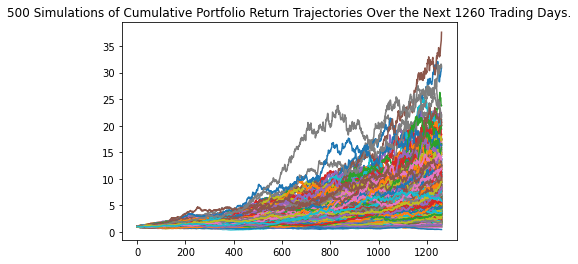

In [18]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 5yr scenario
MC_even_weight_line_5yr_plot = MC_even_weight_5yr.plot_simulation()


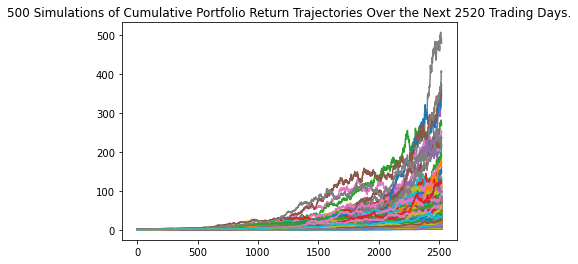

In [19]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 10yr scenario

MC_even_weight_line_10yr_plot = MC_even_weight_10yr.plot_simulation()

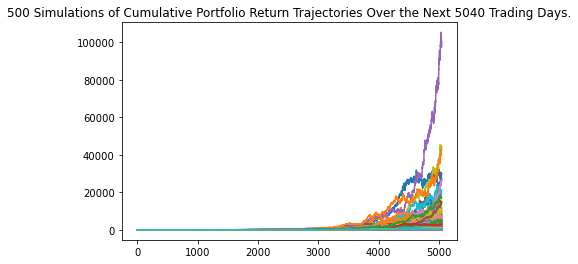

In [20]:
# Visualize the Monte Carlo simulation by creating an overlay line plot for the 20yr scenario
MC_even_weight_line_20yr_plot = MC_even_weight_20yr.plot_simulation()

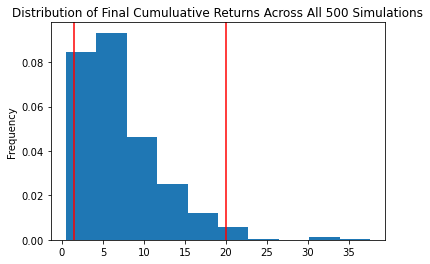

In [21]:
# Here we visualize the probability distribution of the Monte Carlo simulation 
# based on the user's timeframe by plotting a histogram
#Changed on 2021-11-02 by Paul Lopez. We are now plotting for all 3 time horizons of 5yr, 10yr, and 20yr.
MC_even_weight_5yr_distibution_plot = MC_even_weight_5yr.plot_distribution()

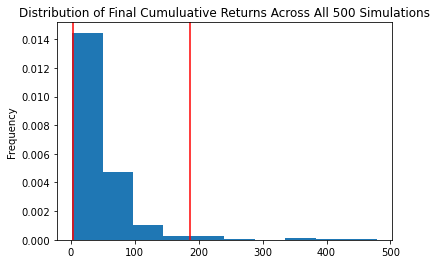

In [22]:
MC_even_weight_10yr_distibution_plot = MC_even_weight_10yr.plot_distribution()

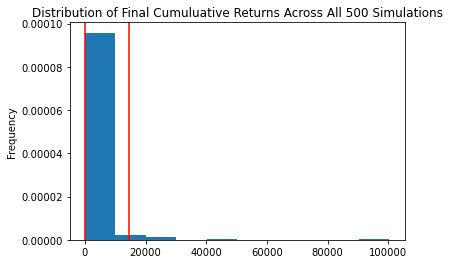

In [23]:
MC_even_weight_20yr_distibution_plot = MC_even_weight_20yr.plot_distribution()

#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [24]:
# Generate summary statistics from the Monte Carlo simulation 5yr results
# We save the results as a variable
MC_even_weight_5yr_summary_table = MC_even_weight_5yr.summarize_cumulative_return()
# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_5yr_summary_table)

count           500.000000
mean              7.179970
std               4.986868
min               0.461353
25%               3.557192
50%               5.808633
75%               9.428129
max              37.578100
95% CI Lower      1.506835
95% CI Upper     20.017210
Name: 1260, dtype: float64


In [25]:
# Generate summary statistics from the Monte Carlo simulation 10yr results
# We save the results as a variable
MC_even_weight_10yr_summary_table = MC_even_weight_10yr.summarize_cumulative_return()
# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_10yr_summary_table)

count           500.000000
mean             44.825562
std              53.286601
min               2.287979
25%              14.909638
50%              27.902376
75%              57.321201
max             478.215266
95% CI Lower      4.100878
95% CI Upper    185.838559
Name: 2520, dtype: float64


In [26]:
# Generate summary statistics from the Monte Carlo simulation 20yr results
# We save the results as a variable
MC_even_weight_20yr_summary_table = MC_even_weight_20yr.summarize_cumulative_return()
# Review the Client's Monte Carlo summary statistics
print(MC_even_weight_20yr_summary_table)

count              500.000000
mean              2412.102532
std               6344.985209
min                 12.809622
25%                358.237067
50%                804.453664
75%               1909.713380
max             100276.578680
95% CI Lower        54.565856
95% CI Upper     14506.658467
Name: 5040, dtype: float64


In [27]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_5yr = round(MC_even_weight_5yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 5 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_5yr} and ${ci_upper_thirty_cumulative_return_5yr}.")

There is a 95% chance that the current value of $10000000.00 in the portfolio with an even 20% weight in each stock over the next 5 years will end within the range of $15068345.1 and $200172096.72.


In [28]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_10yr = round(MC_even_weight_10yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 10 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_10yr} and ${ci_upper_thirty_cumulative_return_10yr}.")

There is a 95% chance that the current value of $10000000.00 in the portfolio with an even 20% weight in each stock over the next 10 years will end within the range of $41008782.04 and $1858385591.64.


In [29]:
# We now use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes 
#for the current client portfolio
ci_lower_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[8]*portfolio_value,2)
ci_upper_thirty_cumulative_return_20yr = round(MC_even_weight_20yr_summary_table[9]*portfolio_value,2)

# Print the result of your calculations
print(f"There is a 95% chance that the current value of ${portfolio_value:.2f} in the portfolio with an "
      f"even 20% weight in each stock over the next 20 years will end within the range of"
      f" ${ci_lower_thirty_cumulative_return_20yr} and ${ci_upper_thirty_cumulative_return_20yr}.")

There is a 95% chance that the current value of $10000000.00 in the portfolio with an even 20% weight in each stock over the next 20 years will end within the range of $545658561.51 and $145066584671.86.


In [30]:
#created dictionary to store values for csv file
#client_info_dict = {
    #"Value of Portfolio" : [f"${portfolio_value:.2f}","-","-","-","-"],
    #"Value Per Share" : [f"${value_per_share:.2f}", f"${value_per_share:.2f}", f"${value_per_share:.2f}",
     #                    f"${value_per_share:.2f}", f"${value_per_share:.2f}"],
    #"Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4]],
    #"Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}", f"{stock4_shares:.0f}", f"{stock5_shares:.0f}"]    }  
#print(client_info_dict)

In [31]:
#created dataframe from dictionary
#client_info_df = pd.DataFrame(client_info_dict)
#client_info_df.set_index("Value of Portfolio")

In [32]:
#created csv with dataframe
#client_info_df.to_csv("Client Info.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [33]:
#created dictionary to turn into a csv file
#report_details_dict = {
 #   "Holding Period" : ["5year", "10year", "20year"],
  #  "Lower Bound Values" : [f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
   #                f"${ci_lower_thirty_cumulative_return_20yr}"],
    #"Upper Bound Values" : [f"${ci_upper_thirty_cumulative_return_5yr}",f"${ci_upper_thirty_cumulative_return_10yr}",
     #              F"${ci_upper_thirty_cumulative_return_20yr}"]}

In [34]:
#created dataframe with dictionary
#report_details_df = pd.DataFrame(report_details_dict)
#report_details_df.set_index("Holding Period")

In [35]:
# created csv file with dataframe
#report_details_df.to_csv("Report Details.csv", index=False) #moved to util folder function 20211103 Paul Lopez

In [36]:
#joining the dataframes together for the final report.
#joined_dataframes = pd.concat([client_info_df, report_details_df], axis=1)
#reviewing the joined dataframes to check for NAN's.
#joined_dataframes

In [37]:
#replacing NAN's with "-" to make the dataframe more user friendly.
#joined_dataframes = joined_dataframes.fillna("-")
#reviewing joined dataframes to check if the NAN's were replaced.
#joined_dataframes

In [40]:
#created dictionary for final report. updated by chaim 20211104
final_report_dict = {
    "Value of Portfolio" : [f"${portfolio_value:.2f}","-","-","-","-", "Holding Period", "5Year", "10Year", "20Year"],
    "Value Per Share" : [f"${value_share1:.2f}", f"${value_share2:.2f}", f"${value_share3:.2f}",
                         f"${value_share4:.2f}", f"${value_share5:.2f}", "Lower Bound Values",  
                         f"${ci_lower_thirty_cumulative_return_5yr}",f"${ci_lower_thirty_cumulative_return_10yr}",
                         f"${ci_lower_thirty_cumulative_return_20yr}"], 
    "Portfolio Tickers" : [tickers[0], tickers[1], tickers[2], tickers[3], tickers[4], "Upper Bound Values", 
                           f"${ci_upper_thirty_cumulative_return_5yr}",
                           f"${ci_upper_thirty_cumulative_return_10yr}",
                           f"${ci_upper_thirty_cumulative_return_20yr}"],
    "Shares per Ticker" : [f"{stock1_shares:.0f}", f"{stock2_shares:.0f}",f"{stock3_shares:.0f}",
                           f"{stock4_shares:.0f}", f"{stock5_shares:.0f}","-","-","-","-"]}
                           

In [41]:
#created a dataframe from the dictionary.
final_report_df = pd.DataFrame(final_report_dict)
final_report_df

,Value of Portfolio,Value Per Share,Portfolio Tickers,Shares per Ticker
0,$10000000.00,$2558766.09,FB,7558
1,-,$2673995.05,AAPL,17773
2,-,$63597.47,TSLA,55
3,-,$1268812.68,HD,3442
4,-,$3434828.71,GS,8409
5,Holding Period,Lower Bound Values,Upper Bound Values,-
6,5Year,$15068345.1,$200172096.72,-
7,10Year,$41008782.04,$1858385591.64,-
8,20Year,$545658561.51,$145066584671.86,-


In [42]:
#wrote the dataframe to a csv file to present for final report.
#writeToCSV("Client_Info.csv", "Report_Details.csv",client_info_df, report_details_df)
writeToCSV("FinalReport.csv", final_report_df) #updated by Chaim 20211104

Reports have been saved. Have a nice day!


In [44]:
#Adding Pie Chart of weights for each ticker in the portfolio
weights_df =  pd.DataFrame({"weight": weights_eff}, index=[tickers[0], tickers[1],tickers[2],tickers[3],tickers[4]])
# Display the weights_df DataFrame
weights_df

,weight
FB,0.255877
AAPL,0.267400
TSLA,0.006360
HD,0.126881
GS,0.343483


<AxesSubplot:title={'center':'Portfolio Composition'}, ylabel='weight'>

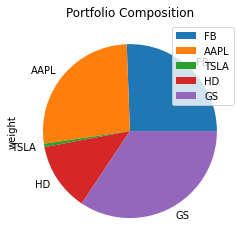

In [45]:
weights_df.plot.pie(y='weight' , title='Portfolio Composition')